In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.animation as animation

import requests

import time
import datetime

from mpl_finance import candlestick_ohlc

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.figsize'] = (16, 8)
# recet to matplotlib standards
#jtplot.reset()

# matplotlib overrides
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Data collection

In [10]:
def fetch_yahoo_data(ticker, provider, start, end):

    try:
        if provider == 'yahoo':
            print('Fetching {ticker} data...'.format(ticker=ticker))
            df = web.DataReader(ticker, provider, start, end)

            df.to_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', index=True, header=True)
            print('Fetching {ticker} data complete.'.format(ticker=ticker))
            time.sleep(2)

    except Exception as e:
        print('Fetch ticker data: ', e)


def main():
    tickers = ['PFE.DE', 'MSF.DE', 'AMZ.DE']
    provider = 'yahoo'
    start = datetime.datetime(2015, 1, 1)
    end = datetime.datetime.today()

    for ticker in tickers:
        fetch_yahoo_data(ticker, provider, start, end)
        
        
main()

Fetching PFE.DE data...


C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)


Fetching PFE.DE data complete.
Fetching MSF.DE data...


C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)


Fetching MSF.DE data complete.
Fetching AMZ.DE data...


C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)


Fetching AMZ.DE data complete.


C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)


In [182]:
tickers = ['MSF.DE', 'PFE.DE']
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.today()

for i, ticker in enumerate(tickers):
    if i == 0:
        df_events = web.DataReader(ticker, 'yahoo-actions', start, end)
        df_events = df_events[df_events['action']=='DIVIDEND']
        df_events.columns = ['Ticker', 'Dividend']
        df_events['Year'] = df_events.index.strftime('%Y')
        df_events['Month'] = df_events.index.strftime('%b')
        df_events['Month Year'] = df_events.index.strftime('%b-%Y')
        df_events = pd.DataFrame(df_events.replace('DIVIDEND', '{ticker}'.format(ticker=ticker)))
        df = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
        df_events = pd.merge(df_events, df['Close'], right_index=True, left_index=True)
        df_events['Dividend Yield'] = df_events['Dividend'] / df_events['Close'] * 100
        
    elif i != 0:
        df_events_conc = web.DataReader(ticker, 'yahoo-actions', start, end)
        df_events_conc = df_events_conc[df_events_conc['action']=='DIVIDEND']
        df_events_conc.columns = ['Ticker', 'Dividend']
        df_events_conc['Year'] = df_events_conc.index.strftime('%Y')
        df_events_conc['Month'] = df_events_conc.index.strftime('%b')
        df_events_conc['Month Year'] = df_events_conc.index.strftime('%b-%Y')
        df_events_conc = pd.DataFrame(df_events_conc.replace('DIVIDEND', '{ticker}'.format(ticker=ticker)))
        df = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
        df_events_conc = pd.merge(df_events_conc, df['Close'], right_index=True, left_index=True)
        df_events_conc['Dividend Yield'] = df_events_conc['Dividend'] / df_events_conc['Close'] * 100
        
        #combine with first df
        df_events = pd.concat([df_events, df_events_conc])
        
        
        
df_events

C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)
C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)


,Ticker,Dividend,Year,Month,Month Year,Close,Dividend Yield
2019-05-15,MSF.DE,0.46,2019,May,May-2019,112.400002,0.409253
2019-02-20,MSF.DE,0.46,2019,Feb,Feb-2019,94.519997,0.486670
2018-11-14,MSF.DE,0.46,2018,Nov,Nov-2018,93.279999,0.493139
2018-08-15,MSF.DE,0.42,2018,Aug,Aug-2018,95.059998,0.441826
2018-05-16,MSF.DE,0.42,2018,May,May-2018,82.120003,0.511447
2018-02-14,MSF.DE,0.42,2018,Feb,Feb-2018,72.230003,0.581476
2017-11-15,MSF.DE,0.42,2017,Nov,Nov-2017,70.580002,0.595069
2017-08-15,MSF.DE,0.39,2017,Aug,Aug-2017,62.299999,0.626003
2017-05-16,MSF.DE,0.39,2017,May,May-2017,62.119999,0.627817
2017-02-14,MSF.DE,0.39,2017,Feb,Feb-2017,60.730000,0.642187


In [124]:
df_events_conc

,Ticker,Dividend,Year,Month,Month Year
2019-08-01,PFE.DE,0.36,2019,Aug,Aug-2019
2019-05-09,PFE.DE,0.36,2019,May,May-2019
2019-01-31,PFE.DE,0.36,2019,Jan,Jan-2019
2018-11-08,PFE.DE,0.34,2018,Nov,Nov-2018
2018-08-02,PFE.DE,0.34,2018,Aug,Aug-2018
2018-05-10,PFE.DE,0.34,2018,May,May-2018
2018-02-01,PFE.DE,0.34,2018,Feb,Feb-2018
2017-08-02,PFE.DE,0.32,2017,Aug,Aug-2017
2017-05-10,PFE.DE,0.32,2017,May,May-2017
2017-02-01,PFE.DE,0.32,2017,Feb,Feb-2017


In [212]:
df_pivot = df_events.pivot(index='Month', columns='Year', values=['Dividend', 'Ticker'])
df_pivot.index = pd.CategoricalIndex(df_pivot.index, categories=['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'])
df_pivot.sort_index()

ValueError: Index contains duplicate entries, cannot reshape

In [229]:
list(df_events[(df_events['Ticker']==ticker) & (df_events['Month Year']=='Feb-2015')]['Dividend']).pop()

2015-02-17    0.31
Name: Dividend, dtype: float64

# Find dividends

In [230]:
years = list(set(df_events['Year']))
years = [int(year) for year in years]
years.sort()
years = [str(year) for year in years]
years

months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

dividend_dates = []
for year in years:
    for month in months:
        dividend_dates.append('{month}-{year}'.format(month=month, year=year))

for t, ticker in enumerate(tickers):
    if t == 0:
        df_dividends = pd.DataFrame(columns=dividend_dates, index=tickers)
                
    elif t != 0:
        pass
    
    for date in dividend_dates:
        df_dividends[date][ticker] = list(df_events[(df_events['Ticker']==ticker) & (df_events['Month Year']=='Feb-2015')]['Dividend']).pop()
        
df_dividends


,Jan-2015,Feb-2015,Mar-2015,Apr-2015,May-2015,Jun-2015,Jul-2015,Aug-2015,Sep-2015,Oct-2015,...,Mar-2019,Apr-2019,May-2019,Jun-2019,Jul-2019,Aug-2019,Sep-2019,Oct-2019,Nov-2019,Dec-2019
MSF.DE,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,...,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31
PFE.DE,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,...,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28


In [ ]:
# GET STOCK INFP
def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)

    result = requests.get(url).json()

    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

get_symbol("AMZ.DE")

# Indicator Calculation

In [167]:
ticker = 'AMZ.DE'

df = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)

df['Simple Moving Average 200'] = df['Close'].rolling(window=200).mean()
df['Simple Moving Average 21'] = df['Close'].rolling(window=21).mean()
df['Exponential Moving Average 200'] = df['Close'].ewm(span=200, adjust=False).mean()
df['Exponential Moving Average 30'] = df['Close'].ewm(span=30, adjust=False).mean()

# Bollinger bands
df['SD 21'] = df['Close'].rolling(window=21).std()
df['Upper Band']= df['Simple Moving Average 21']  + (df['SD 21'] * 2)
df['Lower Band']= df['Simple Moving Average 21']  - (df['SD 21'] * 2)


# RSI
n_rsi = 14

df['Daily Difference'] = df['Close'].diff(1)

df['Upward Movement'] = df['Daily Difference'].mask(df['Daily Difference']<0,0)
df['Downward Movement'] = df['Daily Difference'].mask(df['Daily Difference']>0,0)

df['Average Upward Movement'] = df['Upward Movement'].ewm(com=n_rsi-1, min_periods=n_rsi).mean()
df['Average Downward Movement'] = df['Downward Movement'].ewm(com=n_rsi-1, min_periods=n_rsi).mean()

df['Relative Strength'] = abs(df['Average Upward Movement'] / df['Average Downward Movement'])
df['RSI'] = 100 - (100 / (1 + df['Relative Strength']))


# MACD
n_ema_fast = 12
n_ema_slow = 26

df['EMA Fast'] = df['Close'].ewm(n_ema_fast).mean()
df['EMA Slow'] = df['Close'].ewm(n_ema_slow).mean()
df['MACD'] = df['EMA Fast'] - df['EMA Slow']
df['Signal'] = df['MACD'].ewm(9).mean()

In [168]:
df

,High,Low,Open,Close,Volume,Adj Close,Simple Moving Average 200,Simple Moving Average 21,Exponential Moving Average 200,Exponential Moving Average 30,...,Upward Movement,Downward Movement,Average Upward Movement,Average Downward Movement,Relative Strength,RSI,EMA Fast,EMA Slow,MACD,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,1398.439941,1387.119995,1393.390015,1397.560059,3545.0,1397.560059,NaN,NaN,1397.560059,1397.560059,...,NaN,NaN,NaN,NaN,NaN,NaN,1397.560059,1397.560059,0.000000,0.000000
2018-07-02,1466.699951,1444.130005,1452.000000,1460.089966,3530.0,1460.089966,NaN,NaN,1398.182247,1401.594246,...,62.529907,0.000000,NaN,NaN,NaN,NaN,1430.075610,1429.414917,0.660693,0.347733
2018-07-03,1480.510010,1462.479980,1476.989990,1464.939941,2520.0,1464.939941,NaN,NaN,1398.846502,1405.681065,...,4.849976,0.000000,NaN,NaN,NaN,NaN,1442.638664,1441.706205,0.932459,0.563499
2018-07-04,1466.000000,1455.619995,1457.390015,1456.010010,1507.0,1456.010010,NaN,NaN,1399.415294,1408.928094,...,0.000000,-8.929932,NaN,NaN,NaN,NaN,1446.392893,1445.487065,0.905828,0.663042
2018-07-05,1463.979980,1439.000000,1452.670044,1449.810059,4640.0,1449.810059,NaN,NaN,1399.916734,1411.565640,...,0.000000,-6.199951,NaN,NaN,NaN,NaN,1447.189863,1446.418124,0.771739,0.689585
2018-07-06,1458.000000,1438.250000,1450.500000,1456.849976,2419.0,1456.849976,NaN,NaN,1400.483234,1414.487210,...,7.039917,0.000000,NaN,NaN,NaN,NaN,1449.138300,1448.324833,0.813467,0.716024
2018-07-09,1473.189941,1458.420044,1462.989990,1472.359985,4748.0,1472.359985,NaN,NaN,1401.198425,1418.220937,...,15.510010,0.000000,NaN,NaN,NaN,NaN,1453.302503,1452.159112,1.143391,0.797942
2018-07-10,1493.630005,1478.500000,1485.010010,1486.729980,6716.0,1486.729980,NaN,NaN,1402.049486,1422.640876,...,14.369995,0.000000,NaN,NaN,NaN,NaN,1458.740040,1457.072309,1.667731,0.950662
2018-07-11,1493.819946,1470.000000,1473.500000,1488.949951,3242.0,1488.949951,NaN,NaN,1402.914167,1426.918881,...,2.219971,0.000000,NaN,NaN,NaN,NaN,1463.266105,1461.171947,2.094159,1.137331


In [177]:
web.DataReader('PFF', 'yahoo-actions')


C:\Users\dacatay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\yahoo\actions.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  actions = concat([actions, dividends]).sort_index(ascending=False)


,action,value
2019-08-01,DIVIDEND,0.165
2019-07-02,DIVIDEND,0.161
2019-06-03,DIVIDEND,0.167
2019-05-02,DIVIDEND,0.172
2019-04-01,DIVIDEND,0.180
2019-03-01,DIVIDEND,0.178
2019-02-01,DIVIDEND,0.169
2018-12-18,DIVIDEND,0.258
2018-12-03,DIVIDEND,0.156
2018-11-01,DIVIDEND,0.156


# Fast Plotting

In [169]:
df = df.tail(1000)

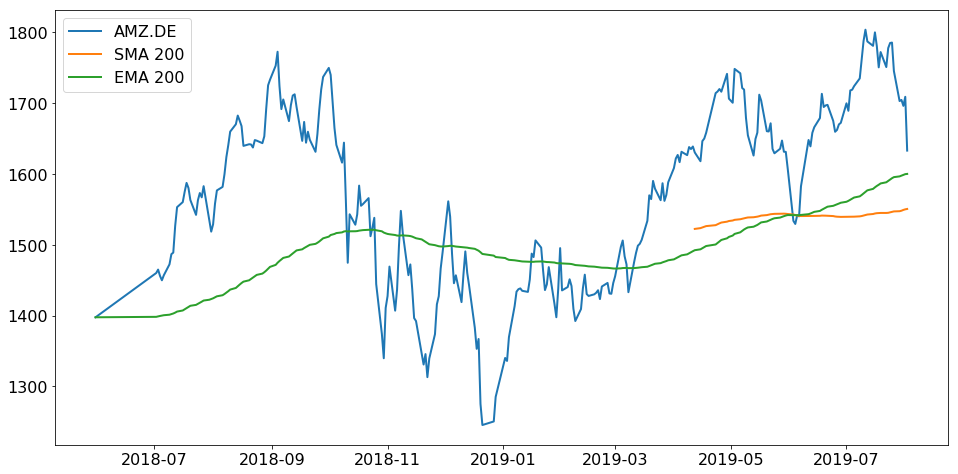

In [170]:
plt.plot(df.index, df['Close'], label='{ticker}'.format(ticker=ticker))
plt.plot(df.index, df['Simple Moving Average 200'], label='SMA 200')
plt.plot(df.index, df['Exponential Moving Average 200'], label='EMA 200')
plt.legend(loc='upper left')
plt.show()

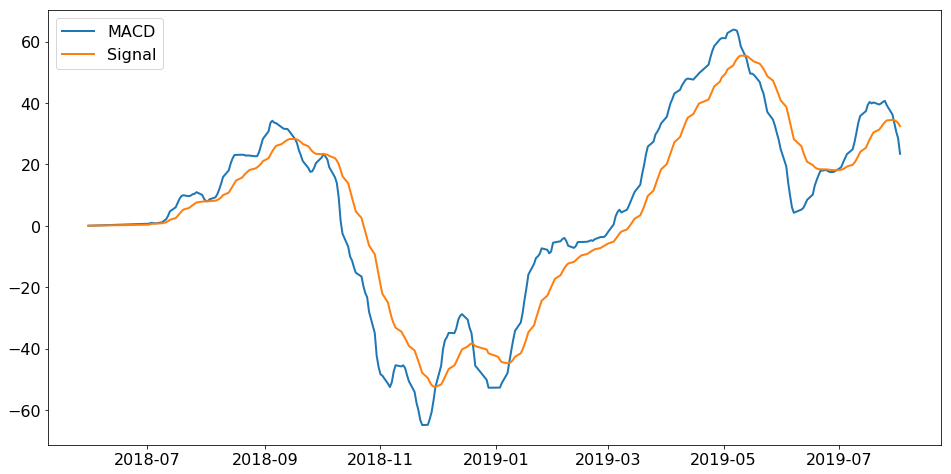

In [171]:
plt.plot(df.index, df['MACD'], label='MACD')
plt.plot(df.index, df['Signal'], label='Signal')
plt.legend(loc='upper left')
plt.show()

# Strong plot

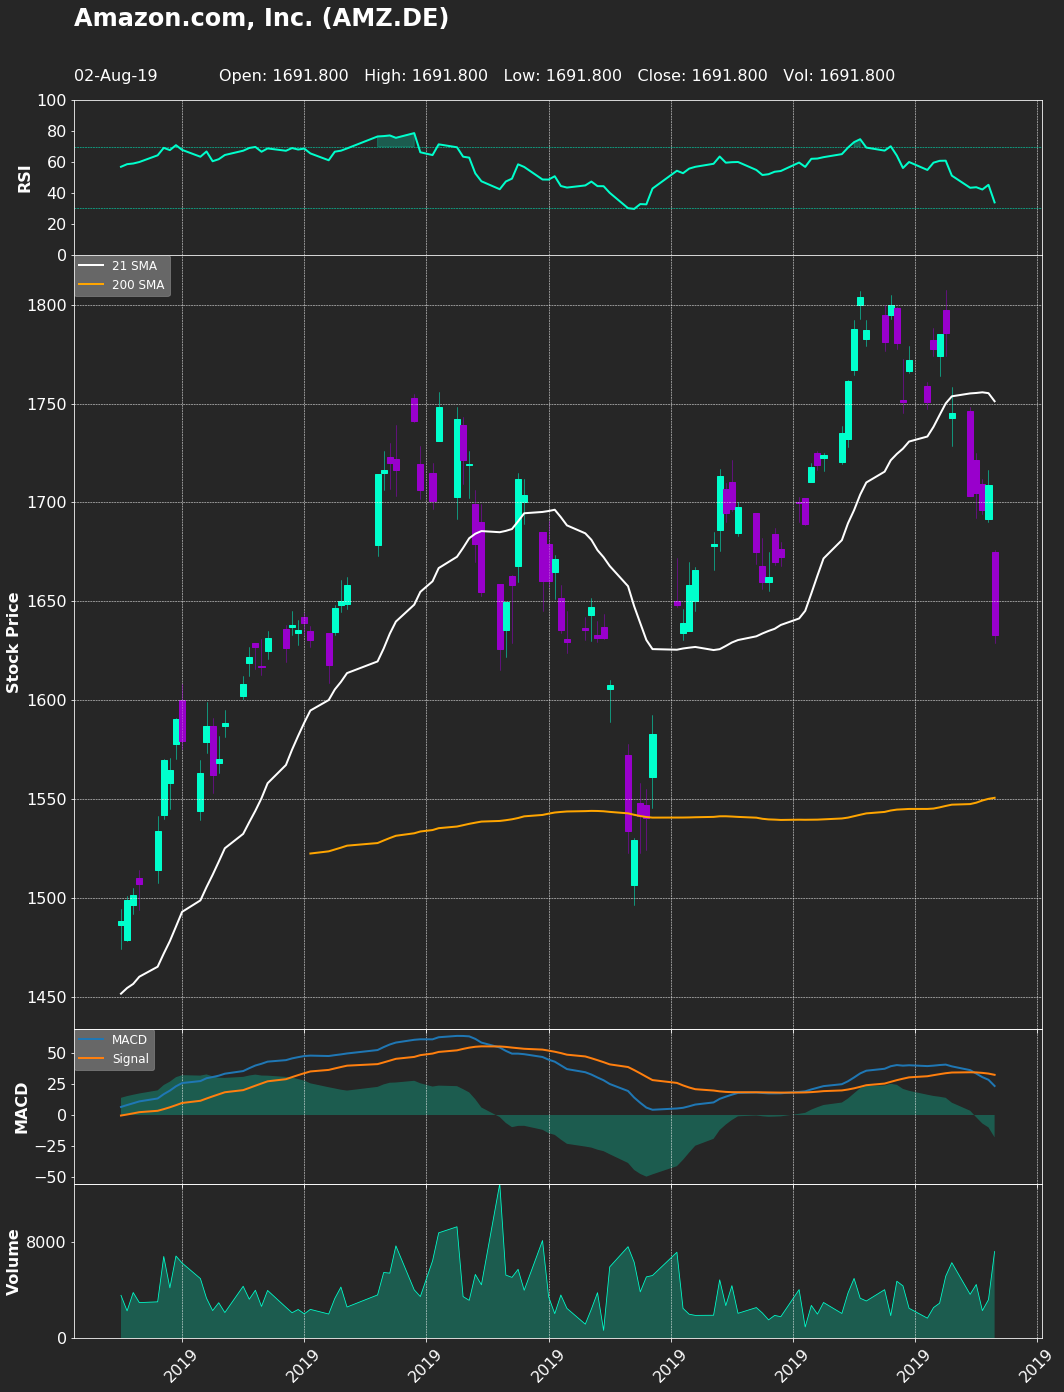

In [175]:
df = df.tail(200)
    
# INITIALIZE FIGURE
fig = plt.figure(figsize=(16,20), facecolor='#262626')
    
# AX4 VOLUME PLOT
ax4 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=4, facecolor='#262626')
ax4.plot(df.index.date, df['Volume'], color='#00ffcc', linewidth=.8)
ax4.fill_between(df.index.date, 0, df['Volume'], facecolor='#00ffcc', alpha=.25)
ax4.yaxis.set_major_locator(mticker.MaxNLocator(2, prune='upper'))
ax4.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
ax4.spines['bottom'].set_color('w')
ax4.spines['top'].set_color('w')
ax4.spines['left'].set_color('w')
ax4.spines['right'].set_color('w')
#ax4.set_ylim(0, 6*df.Volume.max())
ax4.tick_params(axis='both', colors='w')
ax4.margins(y=0, tight=True)
plt.ylabel('Volume', color='w')
        
# label rotation
for label in ax4.xaxis.get_ticklabels():
    label.set_rotation(45)
    # plt.xlabel('Date')
    
    
# AX3 MACD PLOT
ax3 = plt.subplot2grid((8,4), (6, 0), sharex=ax4, rowspan=1, colspan=4, facecolor='#262626')
#ax3.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
#ax3.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
ax3.plot(df.index.date, df['MACD'])
ax3.plot(df.index.date, df['Signal'])
ax3.fill_between(df.index.date, (df['MACD']-df['Signal'])*2, facecolor='#00ffcc', alpha=.25)
ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='upper'))
ax3.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
ax3.spines['bottom'].set_color('w')
ax3.spines['top'].set_color('w')
ax3.spines['left'].set_color('w')
ax3.spines['right'].set_color('w')
ax3.tick_params(axis='both', colors='w')
ax3.yaxis.label.set_color('w')
ax3.xaxis.label.set_color('w')
ax3.axes.xaxis.set_visible(True)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel('MACD')
legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
legend.get_frame().set_alpha(0.3)
legend_text = plt.gca().get_legend().get_texts()
plt.setp(legend_text[0:5], color='w')


# AX1 RSI PLOT  
ax1 = plt.subplot2grid((8, 4), (0, 0), sharex=ax4, rowspan=1, colspan=4, facecolor='#262626')
ax1.plot(df.index.date, df['RSI'], color='#00ffcc')
ax1.axhline(70, color='#00ffcc', linewidth=.5, linestyle='--')
ax1.axhline(30, color='#00ffcc', linewidth=.5, linestyle='--')
ax1.fill_between(df.index.date, df['RSI'], 70, where=(df['RSI']>=70), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
ax1.fill_between(df.index.date, df['RSI'], 30, where=(df['RSI']<=30), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
ax1.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
ax1.spines['bottom'].set_color('w')
ax1.spines['top'].set_color('w')
ax1.spines['left'].set_color('w')
ax1.spines['right'].set_color('w')
ax1.set_ylim(0,100)
ax1.tick_params(axis='both', colors='w')
ax1.yaxis.label.set_color('w')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(5))
plt.ylabel('RSI', color='w')
   
    
# AX2 CANDLESTICK PLOT WITH VOLUME OVERLAY
ax2 = plt.subplot2grid((8, 4), (1, 0), sharex=ax4, rowspan=5, colspan=4, facecolor='#262626')
candlestick_ohlc(ax2, arr, width=1, colorup='#00ffcc', colordown='#9900cc')
ax2.grid(True, color='white', linewidth=.5, linestyle='--')
ax2.xaxis.set_major_locator(mticker.MaxNLocator(10, prune='upper'))
ax2.spines['bottom'].set_color('w')
ax2.spines['top'].set_color('w')
ax2.spines['left'].set_color('w')
ax2.spines['right'].set_color('w')
ax2.tick_params(axis='both', colors='w')
ax2.yaxis.label.set_color('w')
ax2.axes.xaxis.set_visible(True)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Stock Price')
    
#plot averages
ax2.plot(df.index.date, df['Simple Moving Average 21'], label='21 SMA', color='w')
ax2.plot(df.index.date, df['Simple Moving Average 200'], label='200 SMA', color='orange')
legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
legend.get_frame().set_alpha(0.3)
legend_text = plt.gca().get_legend().get_texts()
plt.setp(legend_text[0:5], color='w')

    
# FIGURE TITLE AND FORMATTING OVERALL
#plt.suptitle('{ticker}'.format(ticker=ticker), color='w', horizontalalignment='left')
ax1.text(0, 1.6, '{info} ({ticker})'.format(ticker=ticker, info=get_symbol(ticker)), 
         horizontalalignment='left', verticalalignment='top', color='w', fontsize=24, fontweight='bold', transform=ax1.transAxes)
ax1.text(0, 1.2, '{}'.format(df.tail(1).index.strftime('%d-%b-%y')[0]), 
         horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
ax1.text(0.15, 1.2, 'Open: {0:.3f}   High: {0:.3f}   Low: {0:.3f}   Close: {0:.3f}   Vol: {0:.3f}'.format(df.Open[-1], 
                                                                                                          df.High[-1], 
                                                                                                          df.Low[-1], 
                                                                                                          df.Close[-1],
                                                                                                          df.Volume[-1]), 
         horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
plt.subplots_adjust(left=0.1, bottom=0.09, right=0.94, top=0.95, wspace=0.20, hspace=0)
    
plt.savefig('{ticker}.png'.format(ticker=ticker), facecolor=fig.get_facecolor())
plt.show()

# 